# Multidimensional Pattern identification with SAX
## Cross building/attribute slice

This script performs pattern identification over the {site, attribute} cuboid, which allows exploration of cross-building/attributes combined analysis within a fixed time slice of interested.

The data is first normalized then transformed using SAX over normalized daily sequences. Motifs are identified across buildings, and a final clustering phase is executed over the reduced counts of sequences. 

Results are presented visually allowing interpretable analytics.

In [1]:
# Import modules
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Plotting modules
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
plt.rcdefaults()
# Plotly
import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import plotly.io as pio
# Importing utility script
import utils as ut

# Version
version = "v1.0"

# Path definition
path_data = "..\\data\\cube\\"
path_fig_out = "..\\figures\\cross_blgattrib_slice\\"

## Read

In [2]:
# Read Cuboid
timestamp = "2017-01-01"
df = pd.read_csv(path_data + "cuboid_C_2017-01-01.csv", header=[0,1])
# Drop first row - full of NaNs from multi-column csv format
df.drop(0, axis=0, inplace=True)

# Set & format index
df.set_index(df.columns.values[0], inplace=True)
df.index.rename("timestamp", inplace=True)
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')

# Drop columns full of NaNs
df.dropna(axis=1, how='all', inplace=True)

# Reduce memory usage
df = ut.reduce_mem_usage(df, verbose=True)
df.head()

Mem. usage decreased to  0.17 Mb (74.4% reduction)


electricity                         \
                    Bear_assembly_Angel Bear_assembly_Beatrice   
timestamp                                                        
2017-01-01 00:00:00             220.000                12.2500   
2017-01-01 01:00:00             215.125                 8.6250   
2017-01-01 02:00:00             209.250                 8.7500   
2017-01-01 03:00:00             209.000                 8.8125   
2017-01-01 04:00:00             213.500                 8.9375   

                                                              \
                    Bear_assembly_Danial Bear_assembly_Diana   
timestamp                                                      
2017-01-01 00:00:00             105.5625            0.645508   
2017-01-01 01:00:00              95.8750            0.687500   
2017-01-01 02:00:00              90.3125            0.685547   
2017-01-01 03:00:00              88.3750            0.757324   
2017-01-01 04:00:00              92.8750            0.790527   

                                                             \
                    Bear_assembly_Genia Bear_assembly_Harry   
timestamp                                                     
2017-01-01 00:00:00             208.875             12.3750   
2017-01-01 01:00:00             198.750             11.5625   
2017-01-01 02:00:00             188.000             11.5000   
2017-01-01 03:00:00             185.375             11.5625   
2017-01-01 04:00:00             185.375             11.8750   

                                                                              \
                    Bear_assembly_Jose Bear_assembly_Roxy Bear_assembly_Ruby   
timestamp                                                                      
2017-01-01 00:00:00            158.375             9.0000            48.1250   
2017-01-01 01:00:00            154.875             9.0000            48.1875   
2017-01-01 02:00:00            147.625             9.0000            48.3125   
2017-01-01 03:00:00            146.750             8.9375            48.3750   
2017-01-01 04:00:00            148.500             8.9375            48.2500   

                                            ...      seaLvlPressure  \
                    Bear_education_Alfredo  ... Swan_unknown_Jerold   
timestamp                                   ...                       
2017-01-01 00:00:00               0.090637  ...              1015.5   
2017-01-01 01:00:00               0.093750  ...              1015.0   
2017-01-01 02:00:00               0.093140  ...              1015.5   
2017-01-01 03:00:00               0.092529  ...              1016.0   
2017-01-01 04:00:00               0.090027  ...              1015.5   

                                                             \
                    Swan_unknown_Noelia Swan_unknown_Raquel   
timestamp                                                     
2017-01-01 00:00:00              1015.5              1015.5   
2017-01-01 01:00:00              1015.0              1015.0   
2017-01-01 02:00:00              1015.5              1015.5   
2017-01-01 03:00:00              1016.0              1016.0   
2017-01-01 04:00:00              1015.5              1015.5   

                                                                             \
                    Swan_unknown_Reyna Swan_unknown_Rocco Swan_unknown_Rudy   
timestamp                                                                     
2017-01-01 00:00:00             1015.5             1015.5            1015.5   
2017-01-01 01:00:00             1015.0             1015.0            1015.0   
2017-01-01 02:00:00             1015.5             1015.5            1015.5   
2017-01-01 03:00:00             1016.0             1016.0            1016.0   
2017-01-01 04:00:00             1015.5             1015.5            1015.5   

                                                                              \
                    Swan_unknown_Tom Swan_unknown_Val

# Pre-Mining
## Cross building/attribute motifs identification

In [3]:
# Timerange definition
start_date = df.index.values[0]
end_date = df.index.values[-1]

### OLAP
# Daily averaging
df_d = df.copy().resample('D').mean()
df_d = df_d.transpose().reset_index()
df_d.columns = ["meter", "building_id", "value"]
df_olap = df_d.pivot(index="meter", columns="building_id", values="value")
df_olap = df_olap.dropna(axis=1, how='all').transpose()

# Normalize per column (attribute)
scaler_function = MinMaxScaler() #StandardScaler()
df_olap_normalized = ut.scale_df_columns_NanRobust(df_olap, target_columns=df_olap.columns, scaler=scaler_function)
df_olap_normalized.head()

meter,airTemperature,chilledwater,electricity,gas,hotwater,seaLvlPressure
building_id,,,,,,
Bear_assembly_Angel,NaN,NaN,0.207382,NaN,NaN,NaN
Bear_assembly_Beatrice,NaN,NaN,0.010113,NaN,NaN,NaN
Bear_assembly_Danial,NaN,NaN,0.041239,NaN,NaN,NaN
Bear_assembly_Diana,NaN,NaN,0.000269,NaN,NaN,NaN
Bear_assembly_Genia,NaN,NaN,0.074106,NaN,NaN,NaN


In [7]:
### OLAM
# Data manipulation to get daily SAX
df1 = ut.multi2singlecol_1stCol(df)

# SAX Parameters
day_number_of_pieces = 4
alphabet_size = 3
scaler_function = StandardScaler()

# Normalize per column (here attribute) robust to Nans
columns_considered = ["electricity", "gas", "hotwater", "chilledwater","airTemperature", "seaLvlPressure"]
#columns_considered = [col for col in df_sax.columns if col not in ['building_id', 'timestamp']]
df_normalized = ut.scale_df_columns_NanRobust(df1, target_columns=columns_considered, scaler=scaler_function)

# Now loop over unmerged column to perform SAX
sax_dict, counts, sax_data = dict(), dict(), dict()
dfs = []
for blg in df_normalized['building_id'].unique():
    sax_dict[blg], counts[blg], sax_data[blg] = ut.SAX_mining(df_normalized[columns_considered][df_normalized['building_id'] == blg],
                                                           W=day_number_of_pieces, A=alphabet_size)
    # Append the results to a list
    dfs.append(pd.DataFrame(sax_dict[blg].items(), columns=['Meter', blg]).set_index('Meter'))
# Concatenate the list to a common dataframe
df_sax_dict = pd.concat(dfs, axis=1)

# Post-processing
for col in df_sax_dict.columns:
    df_sax_dict[col] = list(ut.flatten_list([[subitem for subitem in ut.checkIfExists(item)] for item in df_sax_dict[col].values]))

In [8]:
## Visualize cross-building/attribute SAX heatmap

# Pivoting the dataframe for plotting
df_olap_normalized = df_olap_normalized.reindex(columns=columns_considered)
text_list = df_sax_dict.transpose().reindex(columns=columns_considered).values.tolist()
# Plot Heatmap
fig = ut.SAXannotated_heatmap_viz(df_olap_normalized, text_list, timestamp)
# # Inline
# png_output([800,800])
# fig.show()
# Offline
file_name = path_fig_out+"cross_blgattrib_SAX_timeslice_"+timestamp+"_"+version
plotly.offline.plot(fig, filename = file_name, validate=False)
#fig.write_image(path_fig_out+"cross_blgattrib_SAX_timeslice_"+timestamp+"_"+version+".png")

'..\\figures\\cross_blgattrib_slice\\cross_blgattrib_SAX_timeslice_2017-01-01_v1.0.html'

### Grouping identical buildings from multi-attribute sequences together

In [9]:
## Cross-building/attribute SAX counts heatmap

# Pivoting & reindexing the dataframe for plotting
df_text = df_sax_dict.transpose().reindex(columns=columns_considered)
df_olap_normalized = df_olap_normalized.reindex(columns=columns_considered)

#Groupby Object to identify SAX sequence duplicates in cuboid slice
df_text_groupby = df_text.groupby(df_text.columns.values.tolist())
df_text_group = df_text_groupby.size().reset_index()

# Identifying building index list from groupby object with get_group()
one_blg, all_blgs = [], []
for name, group in df_text_groupby:
    one_blg.append(df_text_groupby.get_group(name).index[0])
    all_blgs.append(df_text_groupby.get_group(name).index.values)
# Adding building_id as a new column
df_text_group['building_id'] = one_blg
df_text_group['all_buildings'] = all_blgs
# Set New Index
df_text_group.set_index('building_id', drop=True, inplace=True)
# Dataframe of groupby counts without building index
df_text_group = df_text_group.rename(columns = {0:'count'})
df_text_group.sort_values(by=['count'], ascending=True, inplace=True)

df_text_group.head()

,electricity,gas,hotwater,chilledwater,airTemperature,seaLvlPressure,count,all_buildings
building_id,,,,,,,,
Eagle_health_Reuben,bbbb,None,None,cbbc,bbba,bccc,1,[Eagle_health_Reuben]
Bobcat_assembly_Franklin,bbbb,bbbb,None,None,aaaa,baaa,1,[Bobcat_assembly_Franklin]
Eagle_assembly_Margret,bbbb,None,cccc,cccb,bbba,bccc,1,[Eagle_assembly_Margret]
Eagle_public_Ola,bbbb,None,cccc,bccc,bbba,bccc,1,[Eagle_public_Ola]
Eagle_education_Brooke,bbbb,None,ccbb,cccc,bbba,bccc,1,[Eagle_education_Brooke]


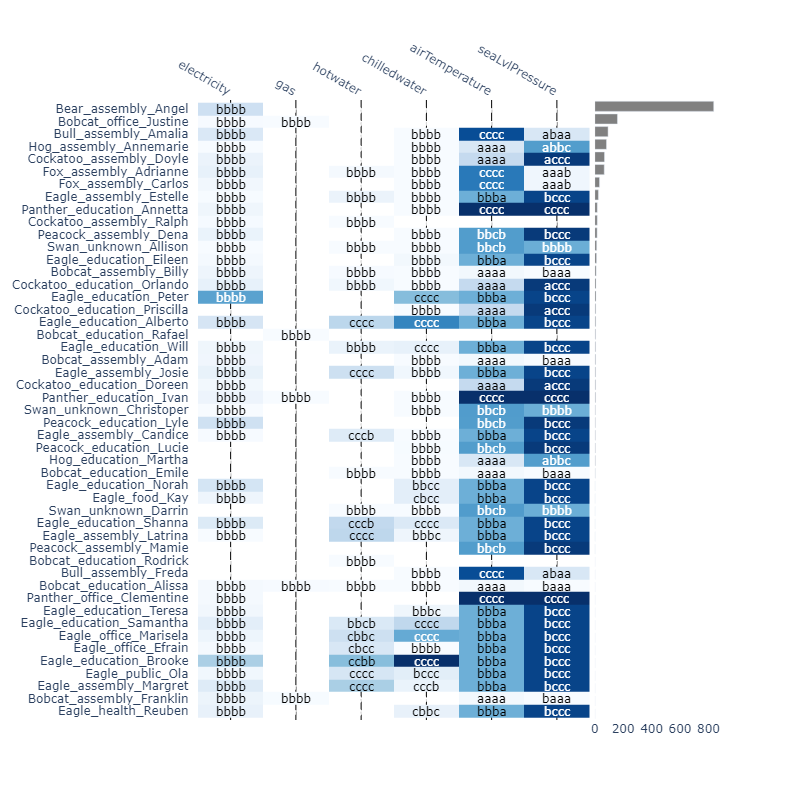

In [10]:
# Heatmap with count plot
fig = ut.SAXannotated_hm_wcounts(df_olap_normalized, df_text_group, timestamp)
ut.png_output([800,800])
fig.show()
fig.write_image(path_fig_out+"cross_blgattrib_SAX_timeslice_"+timestamp+"_reducedwcounts_"+version+".png")

### Sankey Diagram of cross attribute counts

In [13]:
# Creating unique attribute_sequence values for Sankey plotting
df_text_group_sankey = df_text_group.copy()
for col in columns_considered:
    df_text_group_sankey[col] = [col[0:4]+'_']*len(df_text_group_sankey[col]) + df_text_group_sankey[col]
# Re-sorting the frame
df_text_group_sankey.sort_values(by=['count'], ascending=False, inplace=True)
df_text_group_sankey.head()

,electricity,gas,hotwater,chilledwater,airTemperature,seaLvlPressure,count,all_buildings
building_id,,,,,,,,
Bear_assembly_Angel,elec_bbbb,gas_None,hotw_None,chil_None,airT_None,seaL_None,837,"[Bear_assembly_Angel, Bear_assembly_Beatrice, ..."
Bobcat_office_Justine,elec_bbbb,gas_bbbb,hotw_None,chil_None,airT_None,seaL_None,160,"[Bobcat_office_Justine, Bobcat_office_Nikita, ..."
Bull_assembly_Amalia,elec_bbbb,gas_None,hotw_None,chil_bbbb,airT_cccc,seaL_abaa,94,"[Bull_assembly_Amalia, Bull_assembly_Beau, Bul..."
Hog_assembly_Annemarie,elec_bbbb,gas_None,hotw_None,chil_bbbb,airT_aaaa,seaL_abbc,83,"[Hog_assembly_Annemarie, Hog_assembly_Arlie, H..."
Cockatoo_assembly_Doyle,elec_bbbb,gas_None,hotw_None,chil_bbbb,airT_aaaa,seaL_accc,69,"[Cockatoo_assembly_Doyle, Cockatoo_assembly_Em..."


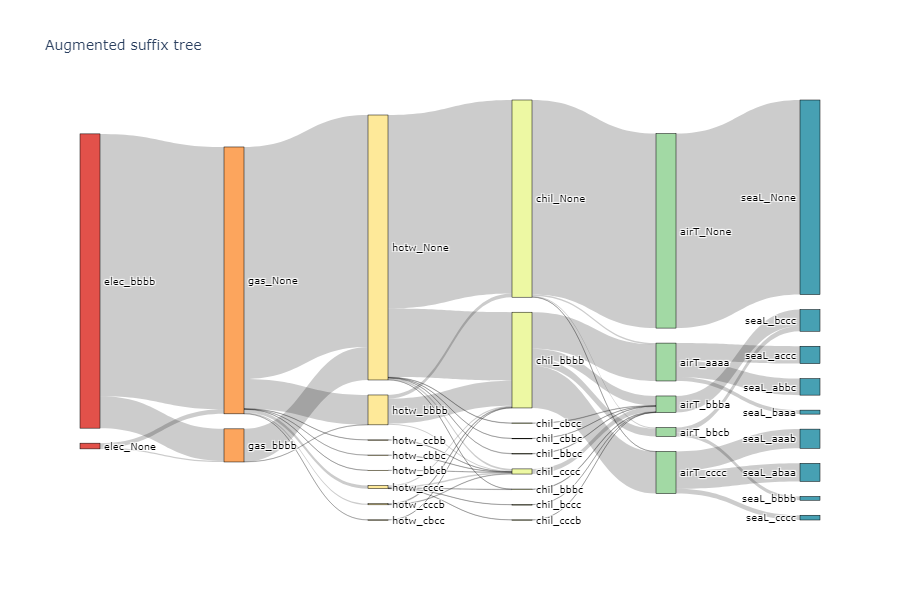

In [14]:
fig = ut.genSankey(df_text_group_sankey,cat_cols=columns_considered,value_cols='count',title='Augmented suffix tree')
# Plot size & format
ut.png_output([900,600])
# Inline plot
fig_plt = go.Figure(fig)
fig_plt.show()
# # Offline plot
# plotly.offline.plot(fig, validate=False)

Lets filter out building groups with fewer than 5 similar sequence counts

In [15]:
# Identify rows of df_text_group with counts fewer than 5
df_text_group_filter = df_text_group[df_text_group['count'] > 5]
df_text_group_filter

,electricity,gas,hotwater,chilledwater,airTemperature,seaLvlPressure,count,all_buildings
building_id,,,,,,,,
Panther_education_Ivan,bbbb,bbbb,None,bbbb,cccc,cccc,6,"[Panther_education_Ivan, Panther_education_Jer..."
Cockatoo_education_Doreen,bbbb,None,None,None,aaaa,accc,6,"[Cockatoo_education_Doreen, Cockatoo_education..."
Eagle_assembly_Josie,bbbb,None,cccc,bbbb,bbba,bccc,6,"[Eagle_assembly_Josie, Eagle_assembly_Lacy, Ea..."
Bobcat_assembly_Adam,bbbb,None,None,bbbb,aaaa,baaa,6,"[Bobcat_assembly_Adam, Bobcat_education_Jayne,..."
Eagle_education_Will,bbbb,None,bbbb,cccc,bbba,bccc,6,"[Eagle_education_Will, Eagle_health_Athena, Ea..."
Bobcat_education_Rafael,None,bbbb,None,None,None,None,6,"[Bobcat_education_Rafael, Lamb_office_Anthony,..."
Eagle_education_Alberto,bbbb,None,cccc,cccc,bbba,bccc,7,"[Eagle_education_Alberto, Eagle_education_Lino..."
Cockatoo_education_Priscilla,None,None,None,bbbb,aaaa,accc,7,"[Cockatoo_education_Priscilla, Cockatoo_health..."
Eagle_education_Peter,bbbb,None,None,cccc,bbba,bccc,9,"[Eagle_education_Peter, Eagle_education_Raul, ..."


# Mining
## Cross building clustering from multi-attribute
Buildings are clustered together from a within time slice view of the data cube. Here multi-attributes are used with clustering leveraging high-dimensional similarity metrics, namely from weigthed averaged multi-attribute daily series.

In [16]:
def rolling_window_fill(df_in, method='median', p_window=4):
    """"A rolling window median/mean filling function.
    p_window=2 - rolling window size (Should be less than 2 hours from C. Fan et al. 2015)
    method='median'/'mean' - choses the method to use for filling"""

    df_manip = df_in.copy()
    for col in df_manip:
    # calculate rolling median/mean
        if method == 'median':
            rm = df_manip[col].rolling(window=p_window, center=True).median()
        elif method == 'mean':
            rm = df_manip[col].rolling(window=p_window, center=True).mean()
        df_manip[col] = rm.ffill(limit=int(p_window/2+1)).bfill(limit=int(p_window/2+1)).interpolate(method='time', axis=0)
    return df_manip

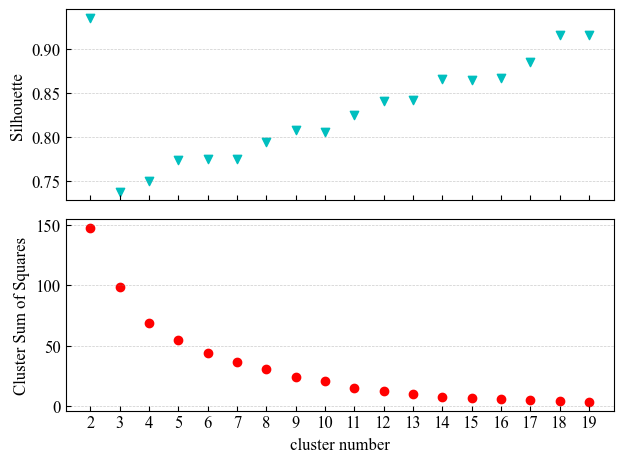

In [17]:
# Scale per attribute across buildings
df_scaled = df.copy()
scaler_function = StandardScaler()
for col in columns_considered:
    df_scaled[col] = ut.scale_NanRobust(df_scaled[col].values, scaler=scaler_function)
df_scaled = ut.multicol_inverseCols(df_scaled)


# Weighted average of attribute time series
def weighted_average(df_in, dict_weights):
    df = df_in.copy()
    # Drop columns full of NaNs
    df.dropna(axis=1, how='all', inplace=True)
    # Identifying remaining columns
    columns_left = df.columns.values.tolist()
    # Creating weight vector from remaining columns
    weights_left = [dict_weights[key] for key in dict_weights.keys() if key in columns_left]
    # Adjusting weights should their total be different from 1
    total_w = sum(weights_left)
    if 1-total_w != 0:
        weights_left = [w * 1/total_w for w in weights_left]
    return np.average(df, weights=weights_left, axis=1)

# Define weight vector
col_key = ['electricity', 'gas', 'hotwater', 'chilledwater', 'airTemperature', 'seaLvlPressure']
weights = [0.6, 0.1, 0.1, 0.1, 0.05, 0.05]
dict_weights = {col_key[i]: weights[i] for i in range(len(col_key))} 

# Identify flat list of all retained buildings
flatList_allBuildings = [ item for elem in df_text_group_filter.all_buildings.values for item in elem]

# Apply averaging per retained building
df_clust = pd.DataFrame(columns=flatList_allBuildings)
for blg in flatList_allBuildings:
    df_clust[blg] = weighted_average(df_scaled[blg], dict_weights)

# Drop columns with more than 50% NaNs
df_clust = df_clust.loc[:, df_clust.isna().mean() < .5]
# Set index
df_clust.index = df_scaled.index
# Interpolate gaps in weather data
df_clust = rolling_window_fill(df_clust, method='mean', p_window=4)
df_clust = df_clust.interpolate(method='linear', limit_direction='both')

# Identify optimal cluster number
wcss, sil = ut.elbow_method(df_clust.transpose(), n_cluster_max=20)
# Plot
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.sans-serif'] = ['Times New Roman']
version = "v1.0.1"
fig = ut.similarity_index_plot(wcss, sil)
fig.savefig(path_fig_out+"CrossBlgAttrib_"+timestamp+"_cluster_SimilarityIndex_"+version+".jpg", dpi=300, bbox_inches='tight')

In [18]:
# Cluster the identified motifs
nb_clusters_opt = 5
kmeans = KMeans(n_clusters=nb_clusters_opt, init='k-means++', max_iter=1600, n_init=10, random_state=0)
kmeans_pred_y = kmeans.fit_predict(df_clust.transpose())

# Identify buildings per cluster
blg_clus = dict()
for clus in range(nb_clusters_opt):
    # Identifying buildings within the cluster
    blg_clus[clus] = df_clust.transpose()[kmeans_pred_y == clus].index.values

# Visualization
df_data = df.copy()
df_data = ut.multicol_inverseCols(df_data)

df_data[blg_clus[clus]].head() #... to complete

Panther_education_Ivan                                   \
                               electricity  gas chilledwater airTemperature   
timestamp                                                                     
2017-01-01 00:00:00               110.8125  0.0     102.0625      15.601562   
2017-01-01 01:00:00                99.5000  0.0      86.6250      15.000000   
2017-01-01 02:00:00                96.8750  0.0      86.6250      15.000000   
2017-01-01 03:00:00                95.8750  0.0      92.7500      13.296875   
2017-01-01 04:00:00                98.4375  0.0      86.6250      12.203125   

                                   Panther_education_Jerome           \
                    seaLvlPressure              electricity      gas   
timestamp                                                              
2017-01-01 00:00:00         1022.0                   439.75  12264.0   
2017-01-01 01:00:00         1021.5                   438.75  12064.0   
2017-01-01 02:00:00         1021.5                   439.25  12152.0   
2017-01-01 03:00:00         1021.5                   439.50  12176.0   
2017-01-01 04:00:00         1021.5                   438.50  12176.0   

                                                                ...  \
                    chilledwater airTemperature seaLvlPressure  ...   
timestamp                                                       ...   
2017-01-01 00:00:00        996.0      15.601562         1022.0  ...   
2017-01-01 01:00:00        949.5      15.000000         1021.5  ...   
2017-01-01 02:00:00        937.0      15.000000         1021.5  ...   
2017-01-01 03:00:00        918.5      13.296875         1021.5  ...   
2017-01-01 04:00:00        912.5      12.203125         1021.5  ...   

                    Panther_office_Garth                Panther_office_Karla  \
                          airTemperature seaLvlPressure          electricity   
timestamp                                                                      
2017-01-01 00:00:00            15.601562         1022.0             18.18750   
2017-01-01 01:00:00            15.000000         1021.5             18.21875   
2017-01-01 02:00:00            15.000000         1021.5             18.21875   
2017-01-01 03:00:00            13.296875         1021.5             17.90625   
2017-01-01 04:00:00            12.203125         1021.5             17.37500   

                                                                \
                    chilledwater airTemperature seaLvlPressure   
timestamp                                                        
2017-01-01 00:00:00          0.0      15.601562         1022.0   
2017-01-01 01:00:00          0.0      15.000000         1021.5   
2017-01-01 02:00:00          0.0      15.000000         1021.5   
2017-01-01 03:00:00          0.0      13.296875         1021.5   
2017-01-01 04:00:00          0.0      12.203125         1021.5   

                    Panther_office_Lavinia                              \
                               electricity chilledwater airTemperature   
timestamp                                                                
2017-01-01 00:00:00              31.281250    24.734375      15.601562   
2017-01-01 01:00:00              30.531250    24.734375      15.000000   
2017-01-01 02:00:00              29.750000    24.734375      15.000000   
2017-01-01 03:00:00              29.609375    24.734375      13.296875   
2017-01-01 04:00:00              30.046875    27.828125      12.203125   

                                    
                    seaLvlPressure  
timestamp                           
2017-01-01 00:00:00         1022.0  
2017-01-01 01:00:00         1021.5  
2017-01-01 02:00:00         1021.5  
2017-01-01 03:00:00         1021.5  
2017-01-01 04:00:00         1021.5  

[5 rows x 177 columns]